 X-Ray Bone Fracture Detection using Digital Image Processing



In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage import exposure, measure
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

In [11]:
def load_images_mura(root_dir, img_size=(128, 128)):
    images, labels = [], []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith((".png", ".jpg", ".jpeg")):
                img_path = os.path.join(root, file)
                label = 1 if "positive" in root.lower() else 0
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, img_size)
                    images.append(img)
                    labels.append(label)
    return np.array(images), np.array(labels)

DATA_DIR = "/kaggle/input/mura-v11/MURA-v1.1/train"
X, y = load_images_mura(DATA_DIR)
print(f"Loaded {len(X)} images.")


Loaded 36808 images.


In [13]:
def preprocess_xray(img):
    p2, p98 = np.percentile(img, (2, 98))
    img = exposure.rescale_intensity(img, in_range=(p2, p98))
    edges = cv2.Canny(img, 50, 150)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    img = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
    return img

In [14]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1760269332.056037      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760269332.056776      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,193 (12.60 MB)

 Trainable params: 3,304,193 (12.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.model_selection import train_test_split

# Normalize and reshape
X = X / 255.0
X = np.expand_dims(X, axis=-1)  # Add channel dimension

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training samples:", X_train.shape)
print("Validation samples:", X_val.shape)

# Setup data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

# Now you can safely train
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs= 50
)


Training samples: (29446, 128, 128, 1)
Validation samples: (7362, 128, 128, 1)
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1760269341.537736     121 service.cc:148] XLA service 0x7ddc80009ab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760269341.539116     121 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1760269341.539136     121 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1760269341.959416     121 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/921 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.5498 - loss: 0.6901

I0000 00:00:1760269346.110349     121 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


921/921 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.5978 - loss: 0.6683 - val_accuracy: 0.5941 - val_loss: 0.6527
Epoch 2/50
921/921 ━━━━━━━━━━━━━━━━━━━━ 36s 39ms/step - accuracy: 0.6045 - loss: 0.6511 - val_accuracy: 0.6323 - val_loss: 0.6343
Epoch 3/50
921/921 ━━━━━━━━━━━━━━━━━━━━ 36s 39ms/step - accuracy: 0.6278 - loss: 0.6384 - val_accuracy: 0.6487 - val_loss: 0.6209
Epoch 4/50
921/921 ━━━━━━━━━━━━━━━━━━━━ 36s 39ms/step - accuracy: 0.6426 - loss: 0.6244 - val_accuracy: 0.6513 - val_loss: 0.6210
Epoch 5/50
921/921 ━━━━━━━━━━━━━━━━━━━━ 36s 40ms/step - accuracy: 0.6551 - loss: 0.6164 - val_accuracy: 0.6797 - val_loss: 0.6007
Epoch 6/50
921/921 ━━━━━━━━━━━━━━━━━━━━ 36s 39ms/step - accuracy: 0.6653 - loss: 0.6087 - val_accuracy: 0.6569 - val_loss: 0.6129
Epoch 7/50
921/921 ━━━━━━━━━━━━━━━━━━━━ 37s 40ms/step - accuracy: 0.6746 - loss: 0.5984 - val_accuracy: 0.6907 - val_loss: 0.5821
Epoch 8/50
921/921 ━━━━━━━━━━━━━━━━━━━━ 36s 39ms/step - accuracy: 0.6820 - loss: 0.5923 - val_accurac

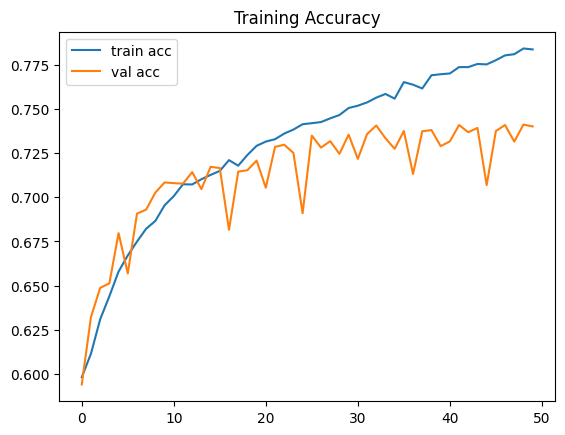

In [18]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Training Accuracy")
plt.show()


/tmp/ipykernel_37/1825818623.py:46: UserWarning: Glyph 128997 (\N{LARGE RED SQUARE}) missing from current font.
  plt.tight_layout()


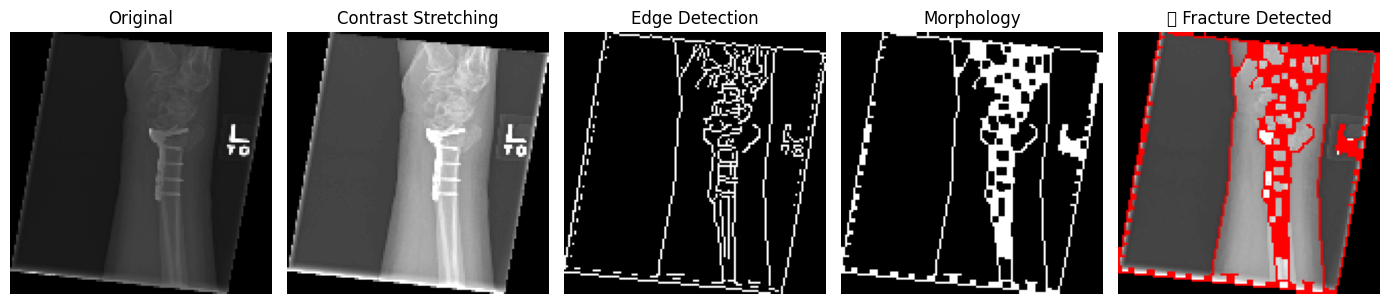

Prediction Score: 0.9732
Final Result: 🟥 Fracture Detected


In [27]:
def enhance_image(img):
    # --- Contrast Stretching ---
    p2, p98 = np.percentile(img, (2, 98))
    contrast_stretched = exposure.rescale_intensity(img, in_range=(p2, p98))

    # --- Edge Detection ---
    edges = cv2.Canny(contrast_stretched, 50, 150)

    # --- Morphological Closing ---
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    morphed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    return contrast_stretched, edges, morphed


# ✅ Complete pipeline to visualize & predict
def highlight_fracture_region(img_path):
    # --- Step 1: Read Image ---
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"❌ Error: Could not read image at {img_path}")
        return

    # --- Step 2: Resize ---
    img_resized = cv2.resize(img, (128,128))

    # --- Step 3: Enhancement ---
    enhanced, edges, morphed = enhance_image(img_resized)

    # --- Step 4: Model Prediction ---
    input_img = np.expand_dims(img_resized/255.0, axis=(0,-1))  # Normalize & reshape
    pred = model.predict(input_img, verbose=0)[0][0]
    result = "🟥 Fracture Detected" if pred > 0.5 else "🟩 Normal"

    # --- Step 5: Overlay regions (optional visualization) ---
    overlay = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2BGR)
    overlay[morphed > 0] = [255, 0, 0]  # Highlight in red

    # --- Step 6: Display all stages ---
    plt.figure(figsize=(14,6))
    plt.subplot(1,5,1); plt.imshow(img_resized, cmap='gray'); plt.title("Original"); plt.axis("off")
    plt.subplot(1,5,2); plt.imshow(enhanced, cmap='gray'); plt.title("Contrast Stretching"); plt.axis("off")
    plt.subplot(1,5,3); plt.imshow(edges, cmap='gray'); plt.title("Edge Detection"); plt.axis("off")
    plt.subplot(1,5,4); plt.imshow(morphed, cmap='gray'); plt.title("Morphology"); plt.axis("off")
    plt.subplot(1,5,5); plt.imshow(overlay); plt.title(result); plt.axis("off")
    plt.tight_layout()
    plt.show()

    # --- Step 7: Print prediction score ---
    print(f"Prediction Score: {pred:.4f}")
    print(f"Final Result: {result}")


# ✅ Test with one X-ray image
test_image_path = "/kaggle/input/mura-v11/MURA-v1.1/train/XR_WRIST/patient00328/study1_positive/image2.png"
highlight_fracture_region(test_image_path)